In [1]:
import os
import cv2
import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torchvision.models.video import r3d_18
from sklearn.metrics import classification_report, confusion_matrix
from tqdm import tqdm
import matplotlib.pyplot as plt
from glob import glob

In [2]:
# 2. Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cuda


In [43]:
data_path = r"C:\Users\yashp\RoadRageDataset"
video_data = []

In [44]:
import pandas as pd
for label in ["fight", "non-fight"]:
    label_path = os.path.join(data_path, label)
    for video_file in glob(os.path.join(label_path, "*.mp4")):
        cap = cv2.VideoCapture(video_file)
        frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        fps = cap.get(cv2.CAP_PROP_FPS)
        width = cap.get(cv2.CAP_PROP_FRAME_WIDTH)
        height = cap.get(cv2.CAP_PROP_FRAME_HEIGHT)
        duration = frames / fps if fps > 0 else 0
        cap.release()
        
        video_data.append({
            "filename": os.path.basename(video_file),
            "class": label,
            "frames": frames,
            "fps": fps,
            "duration_sec": duration,
            "resolution": f"{int(width)}x{int(height)}"
        })

# Convert to DataFrame
df = pd.DataFrame(video_data)
df.head()

,filename,class,frames,fps,duration_sec,resolution
0,F_1.mp4,fight,109,21.72100,5.018185,720x1280
1,F_10.mp4,fight,150,29.97003,5.005000,848x478
2,F_100.mp4,fight,150,30.00000,5.000000,480x854
3,F_101.mp4,fight,150,29.97003,5.005000,848x478
4,F_102.mp4,fight,150,30.00000,5.000000,720x1280


In [45]:
print(df['class'].value_counts())
print(df['class'].unique())


class
fight        306
non-fight    306
Name: count, dtype: int64
['fight' 'non-fight']


In [46]:

import seaborn as sns

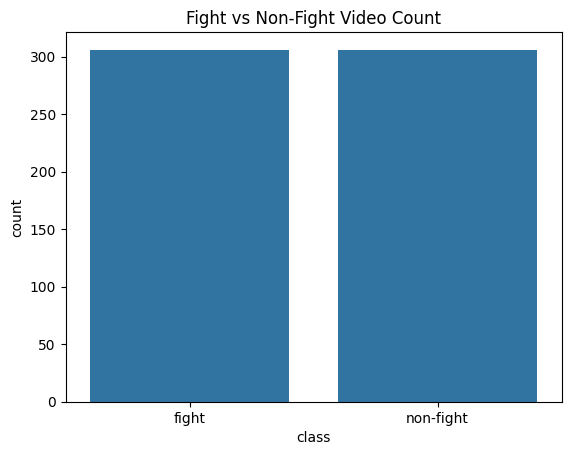

In [47]:
sns.countplot(data=df, x="class")
plt.title("Fight vs Non-Fight Video Count")
plt.show()


Resolution Counts:
 resolution
848x478     239
1280x592    104
640x360      88
720x1280     72
848x384      31
576x1024     11
720x1278     10
480x854       9
572x848       9
1280x720      8
720x720       8
718x1280      8
960x1706      6
640x640       4
574x848       3
592x1296      2
Name: count, dtype: int64


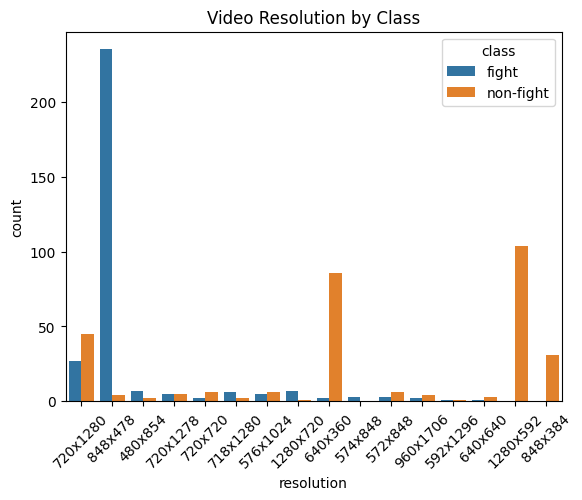

In [49]:
res_counts = df['resolution'].value_counts()
print("Resolution Counts:\n", res_counts)

sns.countplot(data=df, x="resolution", hue="class")
plt.title("Video Resolution by Class")
plt.xticks(rotation=45)
plt.show()


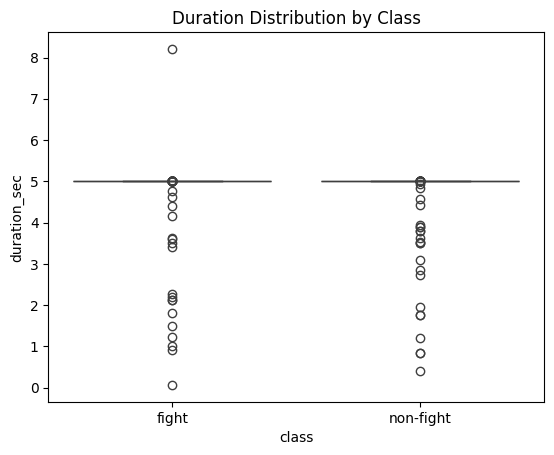

In [50]:
sns.boxplot(data=df, x="class", y="duration_sec")
plt.title("Duration Distribution by Class")
plt.show()


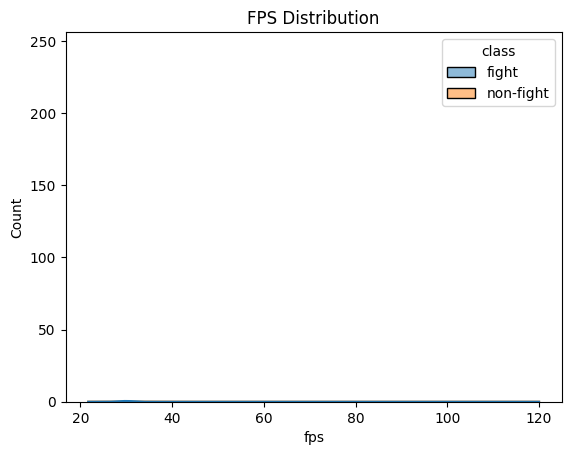

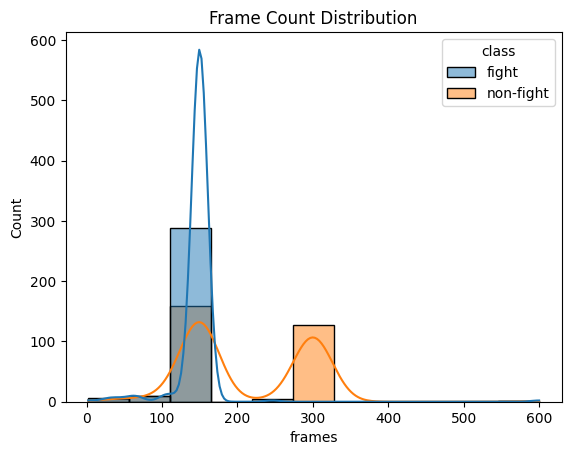

In [51]:
sns.histplot(data=df, x="fps", hue="class", kde=True)
plt.title("FPS Distribution")
plt.show()

sns.histplot(data=df, x="frames", hue="class", kde=True)
plt.title("Frame Count Distribution")
plt.show()


Fight video sample:


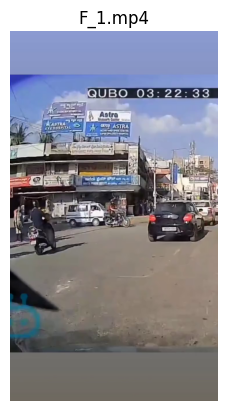

Non-fight video sample:


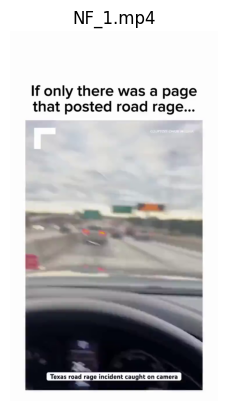

In [55]:
def show_sample_frame(video_path):
    cap = cv2.VideoCapture(video_path)
    ret, frame = cap.read()
    cap.release()
    if ret:
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        plt.imshow(frame)
        plt.axis('off')
        plt.title(os.path.basename(video_path))
        plt.show()

# Show 1 sample from each class
fight_sample = glob(os.path.join(data_path, "fight", "*.mp4"))[0]
non_fight_sample = glob(os.path.join(data_path, "non-fight", "*.mp4"))[0]

print("Fight video sample:")
show_sample_frame(fight_sample)

print("Non-fight video sample:")
show_sample_frame(non_fight_sample)


In [3]:
# 3. Frame Extraction Function
def extract_frames(video_path, num_frames=16):
    cap = cv2.VideoCapture(video_path)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    step = max(1, total_frames // num_frames)

    frames = []
    for i in range(0, total_frames, step):
        cap.set(cv2.CAP_PROP_POS_FRAMES, i)
        ret, frame = cap.read()
        if not ret:
            break
        frame = cv2.resize(frame, (112, 112))
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frames.append(frame)
        if len(frames) == num_frames:
            break
    cap.release()

    # Pad if not enough frames
    while len(frames) < num_frames:
        frames.append(np.zeros((112, 112, 3), dtype=np.uint8))
    return np.array(frames)

In [14]:
# 4. Custom Dataset Class
class RoadRageDataset(Dataset):
    def __init__(self, video_paths, labels, num_frames=16):
        self.video_paths = video_paths
        self.labels = labels
        self.num_frames = num_frames
        self.transform = transforms.Compose([
            transforms.ToTensor()
        ])

    def __len__(self):
        return len(self.video_paths)

    def __getitem__(self, idx):
        frames = extract_frames(self.video_paths[idx], self.num_frames)
        frames = torch.stack([self.transform(frame) for frame in frames])  # (T, C, H, W)
        frames = frames.permute(1, 0, 2, 3)  # --> (C, T, H, W)
        label = torch.tensor(self.labels[idx]).long()
        return frames, label


In [15]:
# 5. Load Data & Split
def load_data(data_path):
    fight_videos = glob(os.path.join(data_path, r"C:\Users\yashp\RoadRageDataset\fight", '*.mp4'))
    non_fight_videos = glob(os.path.join(data_path, r"C:\Users\yashp\RoadRageDataset\non-fight", '*.mp4'))

    video_paths = fight_videos + non_fight_videos
    labels = [1]*len(fight_videos) + [0]*len(non_fight_videos)

    # Shuffle
    combined = list(zip(video_paths, labels))
    np.random.shuffle(combined)
    video_paths, labels = zip(*combined)

    # Split
    split_idx = int(0.8 * len(video_paths))
    train_videos, val_videos = video_paths[:split_idx], video_paths[split_idx:]
    train_labels, val_labels = labels[:split_idx], labels[split_idx:]

    return train_videos, train_labels, val_videos, val_labels

In [16]:
print("Train samples:", len(train_loader.dataset))
print("Val samples:", len(val_loader.dataset))


Train samples: 489
Val samples: 123


In [17]:
# 6. Model Setup
def get_model():
    model = r3d_18(pretrained=True)
    model.fc = nn.Linear(model.fc.in_features, 2)
    return model.to(device)

In [18]:
# 7. Train Function
def train_model(model, train_loader, val_loader, epochs=15):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-4)

    for epoch in range(epochs):
        model.train()
        running_loss = 0
        correct, total = 0, 0

        for videos, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
            videos, labels = videos.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(videos)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            preds = torch.argmax(outputs, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        acc = correct / total
        print(f"Train Loss: {running_loss/len(train_loader):.4f}, Accuracy: {acc:.4f}")
        evaluate_model(model, val_loader)

In [19]:
# 8. Evaluation Function
def evaluate_model(model, val_loader):
    model.eval()
    y_true, y_pred = [], []

    with torch.no_grad():
        for videos, labels in val_loader:
            videos = videos.to(device)
            outputs = model(videos)
            preds = torch.argmax(outputs, dim=1).cpu().numpy()
            y_pred.extend(preds)
            y_true.extend(labels.numpy())

    print("\nClassification Report:\n", classification_report(y_true, y_pred, target_names=["non-fight", "fight"]))
    print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred))


In [20]:
# 9. Run the Pipeline
if __name__ == "__main__":
    data_path = "RoadRageDataset"
    num_frames = 16
    batch_size = 4
    epochs = 10

    train_videos, train_labels, val_videos, val_labels = load_data(data_path)

    train_dataset = RoadRageDataset(train_videos, train_labels, num_frames)
    val_dataset = RoadRageDataset(val_videos, val_labels, num_frames)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    model = get_model()
    train_model(model, train_loader, val_loader, epochs)


Epoch 1/10: 100%|██████████| 123/123 [04:30<00:00,  2.20s/it]


Train Loss: 0.4344, Accuracy: 0.7996

Classification Report:
               precision    recall  f1-score   support

   non-fight       0.92      0.85      0.88        65
       fight       0.84      0.91      0.88        58

    accuracy                           0.88       123
   macro avg       0.88      0.88      0.88       123
weighted avg       0.88      0.88      0.88       123

Confusion Matrix:
 [[55 10]
 [ 5 53]]


Epoch 2/10: 100%|██████████| 123/123 [04:25<00:00,  2.16s/it]


Train Loss: 0.2824, Accuracy: 0.8957

Classification Report:
               precision    recall  f1-score   support

   non-fight       0.98      0.80      0.88        65
       fight       0.81      0.98      0.89        58

    accuracy                           0.89       123
   macro avg       0.90      0.89      0.89       123
weighted avg       0.90      0.89      0.89       123

Confusion Matrix:
 [[52 13]
 [ 1 57]]


Epoch 3/10: 100%|██████████| 123/123 [04:27<00:00,  2.18s/it]


Train Loss: 0.2285, Accuracy: 0.9243

Classification Report:
               precision    recall  f1-score   support

   non-fight       0.96      0.82      0.88        65
       fight       0.82      0.97      0.89        58

    accuracy                           0.89       123
   macro avg       0.89      0.89      0.89       123
weighted avg       0.90      0.89      0.89       123

Confusion Matrix:
 [[53 12]
 [ 2 56]]


Epoch 4/10: 100%|██████████| 123/123 [04:25<00:00,  2.16s/it]


Train Loss: 0.1589, Accuracy: 0.9346

Classification Report:
               precision    recall  f1-score   support

   non-fight       0.90      0.95      0.93        65
       fight       0.94      0.88      0.91        58

    accuracy                           0.92       123
   macro avg       0.92      0.92      0.92       123
weighted avg       0.92      0.92      0.92       123

Confusion Matrix:
 [[62  3]
 [ 7 51]]


Epoch 5/10: 100%|██████████| 123/123 [04:29<00:00,  2.19s/it]


Train Loss: 0.1373, Accuracy: 0.9530

Classification Report:
               precision    recall  f1-score   support

   non-fight       0.92      0.88      0.90        65
       fight       0.87      0.91      0.89        58

    accuracy                           0.89       123
   macro avg       0.89      0.90      0.89       123
weighted avg       0.90      0.89      0.89       123

Confusion Matrix:
 [[57  8]
 [ 5 53]]


Epoch 6/10: 100%|██████████| 123/123 [04:34<00:00,  2.23s/it]


Train Loss: 0.0923, Accuracy: 0.9816

Classification Report:
               precision    recall  f1-score   support

   non-fight       0.94      0.91      0.92        65
       fight       0.90      0.93      0.92        58

    accuracy                           0.92       123
   macro avg       0.92      0.92      0.92       123
weighted avg       0.92      0.92      0.92       123

Confusion Matrix:
 [[59  6]
 [ 4 54]]


Epoch 7/10: 100%|██████████| 123/123 [04:35<00:00,  2.24s/it]


Train Loss: 0.0650, Accuracy: 0.9796

Classification Report:
               precision    recall  f1-score   support

   non-fight       0.94      0.91      0.92        65
       fight       0.90      0.93      0.92        58

    accuracy                           0.92       123
   macro avg       0.92      0.92      0.92       123
weighted avg       0.92      0.92      0.92       123

Confusion Matrix:
 [[59  6]
 [ 4 54]]


Epoch 8/10: 100%|██████████| 123/123 [04:34<00:00,  2.23s/it]


Train Loss: 0.0623, Accuracy: 0.9898

Classification Report:
               precision    recall  f1-score   support

   non-fight       0.92      0.89      0.91        65
       fight       0.88      0.91      0.90        58

    accuracy                           0.90       123
   macro avg       0.90      0.90      0.90       123
weighted avg       0.90      0.90      0.90       123

Confusion Matrix:
 [[58  7]
 [ 5 53]]


Epoch 9/10: 100%|██████████| 123/123 [04:29<00:00,  2.19s/it]


Train Loss: 0.0452, Accuracy: 0.9857

Classification Report:
               precision    recall  f1-score   support

   non-fight       0.96      0.85      0.90        65
       fight       0.85      0.97      0.90        58

    accuracy                           0.90       123
   macro avg       0.91      0.91      0.90       123
weighted avg       0.91      0.90      0.90       123

Confusion Matrix:
 [[55 10]
 [ 2 56]]


Epoch 10/10: 100%|██████████| 123/123 [04:25<00:00,  2.16s/it]


Train Loss: 0.0242, Accuracy: 0.9939

Classification Report:
               precision    recall  f1-score   support

   non-fight       0.92      0.91      0.91        65
       fight       0.90      0.91      0.91        58

    accuracy                           0.91       123
   macro avg       0.91      0.91      0.91       123
weighted avg       0.91      0.91      0.91       123

Confusion Matrix:
 [[59  6]
 [ 5 53]]


In [22]:
  # Save model
torch.save(model.state_dict(), "road_rage_model.pth")

In [23]:
# 1. Load the trained model
def load_model(model_path="road_rage_model.pth"):
    model = r3d_18(pretrained=False)
    model.fc = nn.Linear(model.fc.in_features, 2)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.to(device)
    model.eval()
    return model

In [24]:
# 2. Preprocess video for inference
def preprocess_video(video_path, num_frames=16):
    cap = cv2.VideoCapture(video_path)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    step = max(1, total_frames // num_frames)

    frames = []
    for i in range(0, total_frames, step):
        cap.set(cv2.CAP_PROP_POS_FRAMES, i)
        ret, frame = cap.read()
        if not ret:
            break
        frame = cv2.resize(frame, (112, 112))
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frames.append(frame)
        if len(frames) == num_frames:
            break
    cap.release()

    # Pad if needed
    while len(frames) < num_frames:
        frames.append(np.zeros((112, 112, 3), dtype=np.uint8))

    transform = transforms.ToTensor()
    frames = torch.stack([transform(f) for f in frames])  # (T, C, H, W)
    frames = frames.permute(1, 0, 2, 3)  # (C, T, H, W)
    return frames.unsqueeze(0).to(device)  # Add batch dimension

In [25]:
# 3. Predict class (0 = non-fight, 1 = fight)
def predict(model, video_tensor):
    with torch.no_grad():
        outputs = model(video_tensor)
        probs = torch.softmax(outputs, dim=1)
        pred = torch.argmax(probs, dim=1).item()
        confidence = probs[0][pred].item()
        return pred, confidence

In [26]:
# 4. Main prediction interface
def predict_video(video_path):
    model = load_model("road_rage_model.pth")
    video_tensor = preprocess_video(video_path)
    pred, confidence = predict(model, video_tensor)
    label = "Fight" if pred == 1 else "Non-Fight"
    print(f"Prediction: {label} (Confidence: {confidence*100:.2f}%)")

In [28]:
predict_video(r"C:\Users\yashp\Downloads\istockphoto-2162863868-640_adpp_is.mp4")


C:\Users\yashp\anaconda3\envs\FER_TL\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\yashp\anaconda3\envs\FER_TL\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Prediction: Non-Fight (Confidence: 71.74%)
